# DataSets & Libraries Import

In [17]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
#from pytorch_model_summary import summary
import numpy as np

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()                   
)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
batch_size = 32
train = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print("Image shape of a random sample image : {}".format(training_data[0][0].numpy().shape), end = '\n\n')
print("Training Set:   {} images".format(len(training_data)))
print("Test Set:       {} images".format(len(test_data)))

Image shape of a random sample image : (3, 32, 32)

Training Set:   50000 images
Test Set:       10000 images


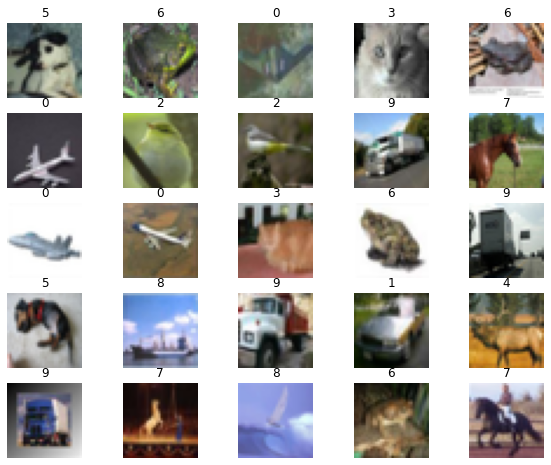

In [19]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.numpy().swapaxes(0,1).swapaxes(1,2))
plt.show()

# NeuralNetwork Model

In [20]:
#need to return an tensor in option A
class Identity(nn.Module):
    
    def __init__(self, lambd):
        super(Identity, self).__init__()
        self.lambd = lambd
    
    def forward(self, x):
        return self.lambd(x)

In [21]:
#will be use as block_type ne
class ConvBlock(nn.Module):
    '''
    ConvBlock will implement the regular ConvBlock and the shortcut block. See figure 2
    When the dimension changes between 2 blocks, the option A or B of the paper are available.
    '''
    def __init__(self, in_channels, out_channels, stride=1, option='A'):
        super(ConvBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        """Implementation of option A (adding pad) and B (conv2d) in the paper for matching dimensions"""

        if stride!=1 or in_channels!=out_channels:
            if option=='A':
                pad_to_add = out_channels//4 #number 4 as said in the paper (4pixels are padded each side)
                padding = (0,0,0,0, pad_to_add, pad_to_add,0,0) #padding the right and bottom of
                self.shortcut = Identity(lambda x:nn.functional.pad(x[:,:,::2,::2], padding))
            if option=='B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, 2*out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                    nn.BatchNorm2d(2*out_channels)
                )

    def forward(self, x):
        out = self.features(x)
        # sum it up with shortcut layer
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [22]:
class ResNetNN(nn.Module):
    """ 
    ResNet-56 architecture for CIFAR-10 DataSet of shape 32*32*3
    """
    def __init__(self, block_type, num_blocks):
        super(ResNetNN, self).__init__()

        self.in_channels = 16 #soit c'est filters soit c'est feature maps

        self.conv0 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(16)
        self.block1 = self.__build_layer(block_type, 16, num_blocks[0], starting_stride=1)
        self.block2 = self.__build_layer(block_type, 32, num_blocks[1], starting_stride=2)
        self.block3 = self.__build_layer(block_type, 64, num_blocks[2], starting_stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) #jsp à quoi ca sert
        self.relu = nn.ReLU()
        self.linear = nn.Linear(64,10) #final activation for classification

    
    def __build_layer(self, block_type, out_channels, num_blocks, starting_stride):
        #create a list of len num_blocks with the first the stride we want then follow by ones
        strides_list_for_current_block = [starting_stride]+[1]*(num_blocks-1)

        #boucle for to create a mutiple layer with de good in_channels and out_channels and the good stride defined above
        layers = []
        for stride in strides_list_for_current_block:
            layers.append(block_type(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)
    
    def forward(self,x):
        out = self.conv0(x)
        out = self.bn0(out)
        out = self.relu(out)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.linear(out)
        return out

In [23]:
def ResNet56():
    return ResNetNN(block_type=ConvBlock, num_blocks=[9,9,9])


model = ResNet56()
#summary(model, torch.Tensor(1,3,32,32))

In [34]:
model.parameters()

<generator object Module.parameters at 0x0000021024BD6740>

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
def train_model():
    EPOCHS = 15
    train_samples_num = 50000
    train_costs, val_costs = [], []
    
    #Training phase.    
    for epoch in range(EPOCHS):

        train_running_loss = 0
        correct_train = 0
                
        for inputs, labels in train:
            
            """ for every mini-batch during the training phase, we typically want to explicitly set the gradients 
            to zero before starting to do backpropragation """
            optimizer.zero_grad()
            
            # Start the forward pass
            prediction = model(inputs)
                        
            loss = criterion(prediction, labels)
          
            # do backpropagation and update weights with step()
            loss.backward()         
            optimizer.step()
            
            # print('outputs on which to apply torch.max ', prediction)
            # find the maximum along the rows, use dim=1 to torch.max()
            _, predicted_outputs = torch.max(prediction.data, 1)
            
            # Update the running corrects 
            correct_train += (predicted_outputs == labels).float().sum().item()
            
            ''' Compute batch loss
            multiply each average batch loss with batch-length. 
            The batch-length is inputs.size(0) which gives the number total images in each batch. 
            Essentially I am un-averaging the previously calculated Loss '''
            train_running_loss += (loss.data.item() * inputs.shape[0])

        
        train_epoch_loss = train_running_loss / train_samples_num
        
        train_costs.append(train_epoch_loss)
        
        train_acc =  correct_train / train_samples_num
        
        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f}"

        test_samples_num = 10000
        correct = 0 

        with  torch.no_grad():
            for inputs, labels in test:
                # Make predictions.
                prediction = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

        test_accuracy = correct / test_samples_num
        print('Test accuracy: {}'.format(test_accuracy))
        
        print(info.format(epoch+1, EPOCHS, train_epoch_loss, train_acc))
                                                                
        
    return train_costs

train_costs = train_model()

Test accuracy: 0.0011
[Epoch 1/15]: train-loss = 1.632350 | train-acc = 0.393
Test accuracy: 0.0013
[Epoch 2/15]: train-loss = 1.027941 | train-acc = 0.635
Test accuracy: 0.001
[Epoch 3/15]: train-loss = 0.767632 | train-acc = 0.732
Test accuracy: 0.0013
[Epoch 4/15]: train-loss = 0.625819 | train-acc = 0.782
Test accuracy: 0.0009
[Epoch 5/15]: train-loss = 0.536124 | train-acc = 0.814
Test accuracy: 0.0013
[Epoch 6/15]: train-loss = 0.452792 | train-acc = 0.843
Test accuracy: 0.0014
[Epoch 7/15]: train-loss = 0.384912 | train-acc = 0.866
Test accuracy: 0.001
[Epoch 8/15]: train-loss = 0.328825 | train-acc = 0.885
Test accuracy: 0.0013
[Epoch 9/15]: train-loss = 0.278589 | train-acc = 0.900
Test accuracy: 0.0014
[Epoch 10/15]: train-loss = 0.232109 | train-acc = 0.918
Test accuracy: 0.0014
[Epoch 11/15]: train-loss = 0.195850 | train-acc = 0.930
Test accuracy: 0.0014
[Epoch 12/15]: train-loss = 0.170651 | train-acc = 0.940
Test accuracy: 0.0012
[Epoch 13/15]: train-loss = 0.145609 | tr

In [27]:
test_samples_num = 10000
correct = 0 


with  torch.no_grad():
    for inputs, labels in test:
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / test_samples_num
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.8136
